<a href="https://colab.research.google.com/github/clincoln8/api-python/blob/drug-discovery/notebooks/Drug_Discovery_With_Data_Commons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drug Discovery via Data Commons

---
Copyright 2020 Google LLC. SPDX-License-Identifier: Apache-2.0

Notebook Version: 1.0

Authors: @calinc, @speikos


# Overview

This Colab tutorial exemplifies how data from the Data Commons Biomedical Knowledge Graph (DC KG) can be applied to help answer real world questions, in this case drug discovery.

Here we will search for approved drugs for novel applications, which is sometimes referred to as drug repurposing. This is an important aspect of drug discovery because it reduces the time and resources required to deliver a treatment to a patient in need. By using drugs that are already approved, this approach eliminates phase I of clinical trials which proves the drug is safe for human use. This is especially important in the realm of rare diseases that have been overlooked by drug funding due to lack of projected profit caused by the small market pool. This reuse of approved compounds allows researchers to find treatments for those with rare disease with less upfront cost for companies to fund. 

The first aspect of drug discovery is to identify candidate compounds from a pool of human approved drugs to be used in a novel application or disease treatment. The Data Commons Biomedical Knowledge Graph (DC KG) is an ideal asset in drug discovery because it resolves many sources of compound and disease related data into one entity, ready to be queried. This notebook will focus on this computational aspect of drug discovery by analyzing drug-gene and disease-gene associations from Data Commons in order to suggest candidate molecules for treatment of a given disease.

## Data Sources
The sources of data retreived from Data Commons in this notebook include [PharmGKB](https://www.pharmgkb.org/) (used for drug-gene associations), [Disease Ontology](https://disease-ontology.org/) (disease-gene associations), and [ChEMBL](https://www.ebi.ac.uk/chembl/) (disease-compound treatments and contraindications) for the specific queries, as well as a multitude of other sources when analyzing the highest ranked candidiate at the end of the notebook. 

Data is retreived from Data Commons via [SPARQL queries](https://docs.datacommons.org/api/python/query.html) and [get_property_values](https://docs.datacommons.org/api/python/property_value.html) from the Data Commons Python API.

## Methods

To find candiate compounds, starting with the name of a disease, we will:
0. Find the Data Commons ID (dcid) for the given disease, ensuring that it is in the knowledge graph. 
1. Identify compounds that are known treatments or contraindications for the disease. (ChEMBL data)
2. Find the genes that are associated with the disease (Disease Ontology data).
3.   Identify drugs that target each associated gene (PharmGKB data). Then, identify all gene targets for the established treatment compounds (PharmGKB data).
4. Eliminate known treatments or contraindications for the disease and separate remaining candidates into two groups: 
  * (a) candidate does not share a gene target with any of the treatment compounds
  * (b) candidate shares a gene target with at least one treatment compound
5. Rank the candidate compounds from group (b) using an external tool called [RDKit](https://www.rdkit.org/docs/Overview.html). This tool will be used to calculate molecular similiarities between the candidates and known treatment compounds that the candidate shares a gene target with.
6. Analyze the top ranked candidate by retreiving more information about it from Data Commons.

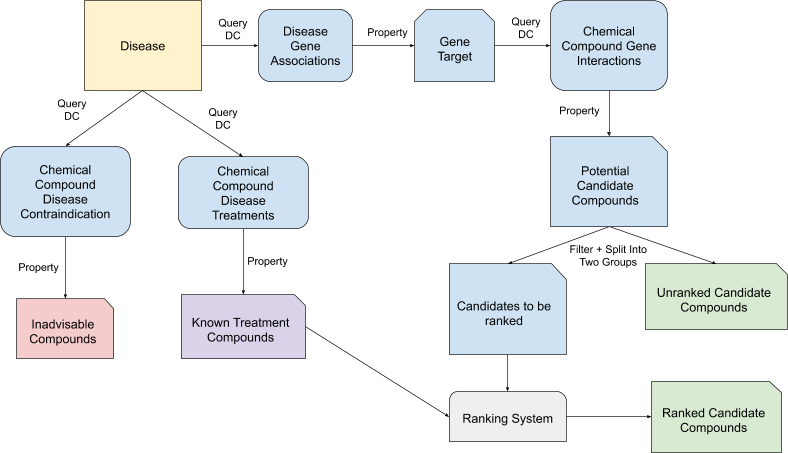

Note: We will be limiting gene targets to hg38 genome assembly for the sake of decreasing size of queries, however Data Commons also contains hg19.

# Requirements

1. Install Data Commons
2. Install RDKit - RDKit cannot be installed with a simple pip command. The [script](https://gist.github.com/philopon/a75a33919d9ae41dbed5bc6a39f5ede2) used here was created to install RDKit in a Colab notebook.

In [ ]:
#@title Install Data Commons
!pip install --upgrade --quiet datacommons


     |████████████████████████████████| 51kB 2.5MB/s 


In [ ]:
#@title Install RDKit
# Install rdkit for molecular similairty calculation 
# source: https://gist.github.com/philopon/a75a33919d9ae41dbed5bc6a39f5ede2

import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()



add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


# Imports
This notebook uses libraries provided by Data Commons, Pandas, and RDKit.

In [ ]:
# Disease Selector Widget
import ipywidgets as widgets

# Data Commons Query 
import datacommons as dc

# RDKit Analysis and Ranking
import pandas as pd
from collections import defaultdict
from ast import literal_eval
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Query Data Commons
In this section, we will be conducting a series of queries to Data Commons to identify candidate compounds. We will first begin by picking a disease we would like to find new treatments for. Then find the treatments and contraindications already known for the disease. We will then find all genes that are associated with the disease, then all compounds that target those identified genes. After filtering out the known treatments and contraindications, we separate these compounds into the two different groups of candidates: those that share at least one gene target with at least one treatment compound and those that do not.


## Query Helper Functions
Below is the main function (`conduct_query`) we will use to query Data Commons with SPARQL. Throughout this tutorial, we will be conducting very large queries. To lessen the load on the Data Commons server, we will use the function below to break up our queries into smaller chunks and space them apart if an error in the server occurs.

In [ ]:
import time
# sets the time between a failed a query and a second attempt to 5 seconds
DELAY_TIME = 5

# sets the maximum number of attempts of a single query to DC as 5
TRIAL_LIMIT = 5

def recursive_query(query_str, trial_num):
  """Queries Data Commons with the given query string.

  If the query results in an error, then this function will be recursively
  called after a delay of DELAY_TIME seconds until the query is resolved or the
  TRIAL_LIMIT has been exceeded.

  Args:
      query_str: The query to be passed to Data Commons.
      trial_num: The number of times the query has been attempted.
  
  Returns:
    The result of the query from Data Commons which is an array of dictionaries.
  
  Raises:
    If the TRIAL_LIMIT is exceeded, then the error thrown by Data Commons is
    raised.
  """
  try:
    return dc.query(query_str) # this is the actual query to Data Commons
  except:
    time.sleep(DELAY_TIME)
    if trial_num < TRIAL_LIMIT:
      return recursive_query(query_str, trial_num+1)
    print('exceeded trial limit: ' + query_str)
    raise

def conduct_query(query_template, query_arr):
  """Generates query strings and intiates queries user helper function.
  
  Chunks the given array into smaller sizes and uses the given template to
  create queries of manageable size for the Data Commons server. Each generated
  query string is passed to the helper function recursive_query.

  Args:
      query_template: The template of the query which needs to be filled in with
          the given array. The template should have only one missing value
          denoted with {0}.
      querry_arr: The array to fill in the given template.
  
  Returns:
      The results of the smaller queries from Data Commons concatonated into one
      result array.
  """
  result = []
  i = 0
  chunk_size = 400

  while (i+chunk_size < len(query_arr)):
    query_str = query_template.format('" "'.join(query_arr[i:i+chunk_size]))
    result.extend(recursive_query(query_str, 0))
    i+= chunk_size

  query_str = query_template.format('" "'.join(query_arr[i:]))
  print(query_str)
  result.extend(recursive_query(query_str, 0))
  return result

## Disease Query 
Let's begin with the common name of a disease for which we'd like to find new candidate drugs. Here, we examine the disease denoted in `disease_name` and identify it's corresponding dcid in Data Commons. Finding the dcid ensures that the disease is in Data Commons and allows us to use it to conduct the rest of queries. The default disease used throughout this tutorial is `Crohn's disease`. 

If you would like to run the notebook with a different disease, first make a copy. Select the cell below labeled `Set Disease Name`. Click "Runtime -> "Run before" from the upper left corner of the Colab notebook. Then run the selected cell. Choose the disease you would like to examine, then seclect the next cell begining with `disease_name` and in the upper left corner, click "Runtime" -> "Run after" to run all of the following cells.

In [ ]:
#@title Set Disease Name
query_str = '''
SELECT ?name
WHERE {
?a typeOf Disease .
?a commonName ?name .
}
'''
result = dc.query(query_str)
disease_name_list = sorted([row['?name'] for row in result], key=str.lower)
disease_selector = widgets.Dropdown(options=disease_name_list, value="Crohn's disease", description='Disease:')

disease_selector

Dropdown(description='Disease:', index=3013, options=('1,4-phenylenediamine allergic contact dermatitis', '1-c…

In [ ]:
disease_name = disease_selector.value
# This query finds a node in Data Commons that is of type Disease and has the 
# common name of the disease we are looking for
query_str = '''
SELECT ?dcid
WHERE {{
?dcid typeOf Disease .
?dcid commonName "{0}" .
}}
'''.format(disease_name)

result = dc.query(query_str)
print('query result: ' + str(result))

disease_dcid = ''

# Extract the dcid of the disease and save it to disease_dcid
for row in result:
  disease_dcid = row['?dcid']

print(disease_dcid)

query result: [{'?dcid': 'bio/DOID_8778'}]
bio/DOID_8778


Now that we have found the dcid of the disease, we can use it in the next few queries.

## Treatments Query
We can examine the properties related to the disease using the `get_property_labels` DC python API function, or we can view the node in the Data Commons Graph Browser. Later on we will see how exactly the `get_property_labels` function is used. This general format for viewing a specific node in Graph Browser is: https://datacommons.org/browser/{dcid}. We will be using this to examine nodes throughout the tutorial. 

From the result above, know that the disease is in Data Commons and its dcid, so let's find all of its known treatments. For now, we can use the Graph Browser to to [view the disease](https://datacommons.org/browser/bio/DOID_8778). 

From this, we see that there is a node type called ChemicalCompoundDiseaseTreatment which pairs a disease and a compound that is known to treat it. After finding the ChemicalCompoundDiseaseTreatment nodes using a SPARQL query to Data Commons, we can use the DC [get_property_values](https://docs.datacommons.org/api/python/property_value.html) API function to find the compoundID involved in each ChemicalCompoundDiseaseTreatment node. 

We will be using this general approach of conducting SPARQL queries followed by calling get_property_values for a majority of the sections below.

In [ ]:
# find all ChemicalCompoundDiseaeTreatment nodes that includes the disease
query_str = '''
SELECT ?cdt_dcid
WHERE {{
?disease dcid "{0}" .
?cdt_dcid typeOf 	ChemicalCompoundDiseaseTreatment .
?cdt_dcid diseaseID ?disease . 
}}
'''.format(disease_dcid)

result = dc.query(query_str)
print('query result: ' + str(result))

treatment_compounds = []

if not result:
  print('no treatments found')

else:
  # extract just the dcids of the ChemicalCompoundDiseaeTreatment nodes
  cdt_dcids = set() 
  for row in result:
    cdt_dcids.add(row['?cdt_dcid'])
  print('CDT dcids: ' + str(cdt_dcids))

  # Use Data Commons python API to get all of the compoundIDs from each CDT Node
  compounds = dc.get_property_values(cdt_dcids, 'compoundID')
  print('raw values:' + str(compounds))

  # Lets reformat this retreived data into a single list of compounds so it is
  # easier to iterate through in the future
  treatment_compounds = [drug for cdt, drug_list in compounds.items() for drug in drug_list ]
  print('treatment compounds: ' + str(treatment_compounds))
  print(len(treatment_compounds))

query result: [{'?cdt_dcid': 'bio/CTD_CHEMBL1200751_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1401_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1201587_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL2109511_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL595_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL393220_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1200796_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL2021430_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1535_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1201438_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1536_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL4297344_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL416_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL90593_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL2108589_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1743068_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1743020_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL131_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL1464_DOID_8778'}, {'?cdt_dcid': 'bio/CTD_CHEMBL74415_DOID_8778'}, {'?cdt_dcid': 

We will save the treatment compounds as a reference to compare the candidate compounds that we find.

## Contraindications Query 

Let's perform the same steps as above, but this time get contraindications for the disease. Data Commons has an entity type called ChemicalCompoundDiseaseContraindication, this pairs a compound with a disease that it should not be used with. We want to ensure that we do not suggest any of these compounds as candidates.

In this specific case, Crohn's disease does not have any contraindications listed in Data Commons, however this is a good check to have when running this notebook with other diseases!

In [ ]:
# This query finds all ChemicalCompoundDiseaeContraindication nodes that the disease is connected to
query_str = '''
SELECT ?cdc_dcid
WHERE {{
?disease dcid "{0}" .
?cdc_dcid typeOf 	ChemicalCompoundDiseaseContraindication .
?cdc_dcid diseaseID ?disease . 
}}
'''.format(disease_dcid)

result = dc.query(query_str)

inadvisable_compounds = []

if not result:
  print('no contraindications found')
else:
  contraindication_dcids = set()
  for row in result:
    contraindication_dcids.add(row['?cdc_dcid'])
  print(contraindication_dcids)

  compounds = dc.get_property_values(contraindication_dcids, 'compoundID')
  print('raw values: ' + str(compounds))

  # reformat compounds into iterable list
  inadvisable_compounds = [drug for cdc, drug_list in compounds.items() for drug in drug_list ]
  print(inadvisable_compounds)
  print(len(inadvisable_compounds))

no contraindications found


Now that we have found a list of inadvisable compounds we have a list of compounds that we should not suggest as candidates.

## Disease-Gene Associations Query 

Let's move on to finding new candidate compounds! After looking at Crohn's disease [in the Graph Browser](https://datacommons.org/browser/bio/DOID_8778), we can see that there is are DiseaseGeneAssociation nodes connected to it. We will use these nodes to find genes associated with the specified disease.

In [ ]:
# This query finds all DiseaseGeneAssociation nodes involving the disease
query_str = '''
SELECT ?dga_dcid
WHERE {{
?disease dcid "{0}" .
?dga_dcid typeOf 	DiseaseGeneAssociation .
?dga_dcid diseaseOntologyID ?disease . 
}}
'''.format(disease_dcid)

all_associated_genes = []
hg38_associated_genes = []

result = dc.query(query_str)

if not result:
  print('no disease-gene associations found')
else:
  # retreive the gene dcids involved in all of the found DiseaseGeneAssociation 
  # nodes, then limit to hg38
  dga_dcids = set()
  for row in result:
    dga_dcids.add(row['?dga_dcid'])
  print('disease-gene asscociations: ' + str(dga_dcids))

  genes_raw = dc.get_property_values(dga_dcids, 'geneID')
  print('raw values: ' + str(genes_raw))

  all_associated_genes = [gene for cdc, gene_list in genes_raw.items() for gene in gene_list ]
  print('all associated genes: ' + str(all_associated_genes))
  print(len(all_associated_genes))

  # limit to hg38 genome assembly
  hg38_associated_genes = [gene for gene in all_associated_genes if gene.startswith('bio/hg38')]
  print('associated hg38 genes: ' + str(hg38_associated_genes))
  print(len(hg38_associated_genes))

disease-gene asscociations: {'bio/DGA_DOID_8778_OSMR_textmining', 'bio/DGA_DOID_8778_CGNL1_textmining', 'bio/DGA_DOID_8778_NR3C1_textmining', 'bio/DGA_DOID_8778_ISG15_textmining', 'bio/DGA_DOID_8778_IL36A_textmining', 'bio/DGA_DOID_8778_SIRT1_textmining', 'bio/DGA_DOID_8778_MXD4_textmining', 'bio/DGA_DOID_8778_PLD4_textmining', 'bio/DGA_DOID_8778_CD177_textmining', 'bio/DGA_DOID_8778_PLG_textmining', 'bio/DGA_DOID_8778_LGALS7B_textmining', 'bio/DGA_DOID_8778_TMEM232_textmining', 'bio/DGA_DOID_8778_MLKL_textmining', 'bio/DGA_DOID_8778_UBE2I_textmining', 'bio/DGA_DOID_8778_GPR132_textmining', 'bio/DGA_DOID_8778_ATXN2_textmining', 'bio/DGA_DOID_8778_COMP_textmining', 'bio/DGA_DOID_8778_EGFR_textmining', 'bio/DGA_DOID_8778_SUCNR1_textmining', 'bio/DGA_DOID_8778_hsa-miR-147b_textmining', 'bio/DGA_DOID_8778_CD6_textmining', 'bio/DGA_DOID_8778_LAT_textmining', 'bio/DGA_DOID_8778_ASPRV1_textmining', 'bio/DGA_DOID_8778_MLLT4_textmining', 'bio/DGA_DOID_8778_GNA11_textmining', 'bio/DGA_DOID_8778_

## Drug-Gene Associations Query 

Using the genes we found above, we can find chemcial compounds that are associated with the genes via ChemicalCompoundGeneAssociation nodes in Data Commons. We will be storing the relationship of candidate to gene targets in the form of a dictionary. Later on, we will use these relationships to rank certain candidates against the the treatment compounds we found earlier.

In [ ]:
# Find ChemicalCompoundGeneAssociation nodes involving the newly found 
# associated genes
query_str = '''
SELECT ?cga_dcid ?gene
WHERE {{
?gene dcid ("{0}") .
?cga_dcid typeOf ChemicalCompoundGeneAssociation .
?cga_dcid geneID ?gene . 
}}
'''

result = conduct_query(query_str, hg38_associated_genes)

candidate_to_genes = {}
print(result)

if not result:
  print('no drug-gene associations found')
else:
  # retreive the compound dcids involved in the found 
  # ChemicalCompoundGeneAssociation nodes
  cga_list = [row['?cga_dcid'] for row in result]
  cga_to_candidate = dc.get_property_values(cga_list, 'compoundID')
  print(cga_to_candidate)
 
  for row in result:
    candidate = cga_to_candidate[row['?cga_dcid']][0]

    # ensure we have limited targets to hg38
    if not row['?gene'].startswith('bio/hg38'):
      continue
    # save candidate to gene targets relationship
    if candidate in candidate_to_genes:
      candidate_to_genes[candidate].add(row['?gene'])
    else:
      candidate_to_genes[candidate] = {row['?gene']}
 
print(candidate_to_genes)
print(len(candidate_to_genes))


SELECT ?cga_dcid ?gene
WHERE {
?gene dcid ("bio/hg38_CXCR3" "bio/hg38_TGFBR2" "bio/hg38_TFF1" "bio/hg38_AUTS2" "bio/hg38_TPM1" "bio/hg38_KLRK1" "bio/hg38_IL12B" "bio/hg38_LTA4H" "bio/hg38_SLC39A14" "bio/hg38_CYP27A1" "bio/hg38_SPINK5" "bio/hg38_SLK" "bio/hg38_DHX9" "bio/hg38_NOTCH4" "bio/hg38_ADORA2A" "bio/hg38_TNFRSF4" "bio/hg38_FGFR2" "bio/hg38_ADCY5" "bio/hg38_PDHX" "bio/hg38_PLAU" "bio/hg38_CCL3L3" "bio/hg38_TIMP2" "bio/hg38_CLEC5A" "bio/hg38_FGF2" "bio/hg38_SLAIN2" "bio/hg38_NGFR" "bio/hg38_RPS6KB1" "bio/hg38_TNFSF15" "bio/hg38_NOXA1" "bio/hg38_DUSP12" "bio/hg38_HTT" "bio/hg38_UGT1A8" "bio/hg38_BSN" "bio/hg38_S100A9" "bio/hg38_GPR68" "bio/hg38_CD4" "bio/hg38_KDR" "bio/hg38_PIP4K2C" "bio/hg38_BDH1" "bio/hg38_NUDT3" "bio/hg38_TNFRSF10D" "bio/hg38_PHACTR1" "bio/hg38_LPA" "bio/hg38_IL31" "bio/hg38_ACKR1" "bio/hg38_IDH1" "bio/hg38_HNF1B" "bio/hg38_VCAM1" "bio/hg38_TCF7L2" "bio/hg38_RPS13" "bio/hg38_TES" "bio/hg38_TNFSF4" "bio/hg38_PROCR" "bio/hg38_AGTR1" "bio/hg38_NFE2" "bio/hg38_TNPO

In [ ]:
len(result)

4218

Now lets conduct the same query to find gene targets, but on the treatment compounds we found earlier. We will later compare candidates to the treatment compounds which share gene targets.

In [ ]:
# Find ChemicalCompoundGeneAssociation nodes involving the treatment compounds
query_str = '''
SELECT ?cga_dcid ?reference_drug
WHERE {{
?reference_drug dcid ("{0}") .
?cga_dcid typeOf ChemicalCompoundGeneAssociation .
?cga_dcid compoundID ?reference_drug
}}
'''
rows = conduct_query(query_str, treatment_compounds)

gene_to_references = {}
print(rows)

if not rows:
  print('no reference compound-gene associations found')
else:
  # extract gene target to treatment compound information
  for row in rows:
    gene = dc.get_property_values([row['?cga_dcid']], 'geneID')[row['?cga_dcid']][0]
   
    # limit to using genome assembly hg38 
    if not gene.startswith('bio/hg38'):
      continue
    # save gene target to treatment compounds mapping
    if gene in gene_to_references:
      gene_to_references[gene].add(row['?reference_drug'])
    else:
      gene_to_references[gene] = {row['?reference_drug']}
print(gene_to_references)


SELECT ?cga_dcid ?reference_drug
WHERE {
?reference_drug dcid ("bio/CHEMBL1542" "bio/CHEMBL90593" "bio/CHEMBL635" "bio/CHEMBL643" "bio/CHEMBL389621" "bio/CHEMBL1743068" "bio/CHEMBL2109070" "bio/CHEMBL1743020" "bio/CHEMBL1201587" "bio/CHEMBL1201567" "bio/CHEMBL116438" "bio/CHEMBL930" "bio/CHEMBL2108326" "bio/CHEMBL866" "bio/CHEMBL393220" "bio/CHEMBL671" "bio/CHEMBL2107614" "bio/CHEMBL3833374" "bio/CHEMBL113" "bio/CHEMBL8" "bio/CHEMBL2104987" "bio/CHEMBL74415" "bio/CHEMBL1742995" "bio/CHEMBL1237023" "bio/CHEMBL2109511" "bio/CHEMBL2108046" "bio/CHEMBL3990031" "bio/CHEMBL262777" "bio/CHEMBL4297252" "bio/CHEMBL1464" "bio/CHEMBL4297331" "bio/CHEMBL450940" "bio/CHEMBL4297344" "bio/CHEMBL1496" "bio/CHEMBL1742996" "bio/CHEMBL186141" "bio/CHEMBL4297761" "bio/CHEMBL1456" "bio/CHEMBL4297477" "bio/CHEMBL1201507" "bio/CHEMBL269732" "bio/CHEMBL384467" "bio/CHEMBL846" "bio/CHEMBL4175981" "bio/CHEMBL3990014" "bio/CHEMBL444633" "bio/CHEMBL1743087" "bio/CHEMBL1201581" "bio/CHEMBL1201479" "bio/CHEMBL4600

## Filter and Split Candidates
After creating a list of candidate drugs, we need to remove any drugs that have been already established as treatment or have been declared as contraindications to the drug. We are left with a set of filtered candidate compounds that might be tested to treat the given disease.

Additionally, we are splitting the candidates into two groups:
* The first group is comprised of candidates that do not share any gene targets with any of the treatment compounds. These candidates will remain unranked as we do not have a basis to compare them to the treatment compounds with. 

* The second group is comprised of the candidates that share at least one gene target with a treatment compound. In the next section, we will be ranking these compounds by comparing their structural similiarity to the treatment compounds they share a gene target with.

In [ ]:
candidates = list(candidate_to_genes.keys()) # all candidates
candidate_to_established_target = defaultdict(list) # group of candidates to be ranked
candidate_to_novel_target = defaultdict(list) # group of candidates to remain unranked

# determine which group each candidate falls under
for candidate in candidates:
  if (candidate in treatment_compounds) or (candidate in inadvisable_compounds):
    continue
  gene_targets = list(candidate_to_genes[candidate])
  for gene_target in gene_targets:
    # check if gene is targeted by a treatment compound
    if gene_target in gene_to_references:
      candidate_to_established_target[candidate].append(gene_target)
    # otherwise add to list of candidates that shall remain unranked
    else:
      candidate_to_novel_target[candidate].append(gene_target)

# candidates that share targets with reference compounds:
print(candidate_to_established_target)
print(len(candidate_to_established_target))

# candidates with novel gene targets:
print(candidate_to_novel_target)
print(len(candidate_to_novel_target))
print('\n')
# create dataframe to store and print the unranked candidates
print('Unranked Candidates with Novel Gene Targets:')
unranked_candidate_df = pd.DataFrame(
    [(key, L) for (key, L) in candidate_to_novel_target.items()], 
                columns=['candidate_dcid', 'gene_target_list'])
unranked_candidate_df

defaultdict(<class 'list'>, {'bio/CHEMBL960': ['bio/hg38_CYP1A2'], 'bio/CHEMBL350239': ['bio/hg38_ABCG2', 'bio/hg38_SLCO1B1', 'bio/hg38_CYP3A5', 'bio/hg38_CYP2C8', 'bio/hg38_ACE', 'bio/hg38_CYP2C9', 'bio/hg38_CYP3A4', 'bio/hg38_CYP2D6', 'bio/hg38_NR1I2', 'bio/hg38_UGT1A1', 'bio/hg38_ABCB1', 'bio/hg38_CYP2C19', 'bio/hg38_HLA-DRB1'], 'bio/PA164713366': ['bio/hg38_CTLA4', 'bio/hg38_HLA-DRB1', 'bio/hg38_HLA-C', 'bio/hg38_TNFAIP3', 'bio/hg38_TNF', 'bio/hg38_TLR4', 'bio/hg38_IL1B'], 'bio/CHEMBL1908360': ['bio/hg38_CYP3A5', 'bio/hg38_CYP2C8', 'bio/hg38_CYP3A4', 'bio/hg38_ABCB1', 'bio/hg38_FGFR4'], 'bio/CHEMBL83': ['bio/hg38_CYP3A5', 'bio/hg38_ABCC2', 'bio/hg38_CYP1A2', 'bio/hg38_CYP3A4', 'bio/hg38_CYP2C9', 'bio/hg38_CYP2D6', 'bio/hg38_NR1I2', 'bio/hg38_ABCB1', 'bio/hg38_CYP2C19', 'bio/hg38_CYP2B6'], 'bio/CHEMBL481': ['bio/hg38_UGT1A6', 'bio/hg38_ABCC1', 'bio/hg38_ABCB1', 'bio/hg38_GSTM1', 'bio/hg38_SLCO1B1', 'bio/hg38_ABCG2', 'bio/hg38_VDR', 'bio/hg38_SHMT1', 'bio/hg38_CYP2A6', 'bio/hg38_ABCC

,candidate_dcid,gene_target_list
0,bio/CHEMBL960,"[bio/hg38_DHODH, bio/hg38_ESR1]"
1,bio/CHEMBL350239,"[bio/hg38_LIPC, bio/hg38_APOE, bio/hg38_SLCO2B..."
2,bio/PA164713366,"[bio/hg38_TNFRSF10A, bio/hg38_SLCO1C1, bio/hg3..."
3,bio/PA164754825,[bio/hg38_CALCA]
4,bio/CHEMBL1908360,"[bio/hg38_ESR2, bio/hg38_MTOR, bio/hg38_ESR1, ..."
...,...,...
515,bio/PA166109554,[bio/hg38_AGTR1]
516,bio/PA166114904,[bio/hg38_TNFSF13B]
517,bio/PA451961,[bio/hg38_SLC30A8]
518,bio/CHEMBL20,[bio/hg38_HLA-B]


The compounds returned in `unranked_candidate_df` are compounds which target disease-associated genes, but these genes are currently not targeted by any known treatment. These compounds could be interesting new treatment approaches, but we will not focus on them for the remainder of this tutorial.

Instead, we will compare the structural similarity of candidate drugs that target the same genes as current treatment drugs. We expect drugs with similar structure to have similar function. We propose that the similarly structured candidate drugs would be good candidates for drug repurposing.

# Ranking Candidates with RDKit
In this section, we will be ranking the candidates from the group that shares at least one gene target with a treatment compound. Throughout this section, treatment compounds will be refered to as the reference compounds. To rank the candidates against the reference compounds, we will be using [Tanimoto Coefficients](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3) to quantify the structural similarities between the compounds. 

We will be using the Simplified Molecular Input Line Entry System (SMILES) taken from Data Commons to describe the structure of each compound. From the SMILES, RDKit encodes the compound structure via Morgan Fingerprinting, then determines the Tanimoto Coefficient based on the the computed fingerprints. The closer the coefficient is to 1, the more structurally similar the two molecules are.

Two molecules are considered similar if their Tanimoto coefficient is greater than 0.85. This does not guarantee that the drugs share similiar behavior in the body, but gives us reason to suspect that they might. This makes them candidates for follow-up research on using the drug to treat a disease of interest.

The steps for ranking the candidates will be:
1. Find SMILES for the reference compounds.
2. Find SMILES for the candidates and store the SMILES + dcid into a pandas DataFrame called ranked_candidate_df.
3. For each gene target of a single candidate, find the Tanimoto Coefficient between the candidiate and  each of reference compound that shares the target, saving the highest coefficient for that gene target.
4. Save each of the highest coefficients for each gene target into an array into a list,while saving the pairings of candidate, gene target, reference compound, and coefficient all as columns of the ranked_candidate_df DataFrame.
5. Sort ranked_candidate_df based on the calculated Tanimoto Coefficients to get a sorted DataFrame of candidates.


### Get Reference SMILES
First we begin by querying Data Commons for SMILES of the reference molecules. The smiles and dcids of the reference molecules are saved in the dictionary called reference_drugs.

In [ ]:
# get SMILES for reference drugs, store in reference_drugs dict
query_str = '''
SELECT ?smiles ?drug
WHERE {{
?drug dcid ("{0}") .
?drug simplifiedMolecularInputLineEntrySystem ?smiles . 
}}
'''

result = conduct_query(query_str, treatment_compounds)
print(result)

reference_drugs = {}

if not result:
  print('no smiles found')
else:
  for row in result:
    reference_drugs[row['?drug']] = row['?smiles']



SELECT ?smiles ?drug
WHERE {
?drug dcid ("bio/CHEMBL1542" "bio/CHEMBL90593" "bio/CHEMBL635" "bio/CHEMBL643" "bio/CHEMBL389621" "bio/CHEMBL1743068" "bio/CHEMBL2109070" "bio/CHEMBL1743020" "bio/CHEMBL1201587" "bio/CHEMBL1201567" "bio/CHEMBL116438" "bio/CHEMBL930" "bio/CHEMBL2108326" "bio/CHEMBL866" "bio/CHEMBL393220" "bio/CHEMBL671" "bio/CHEMBL2107614" "bio/CHEMBL3833374" "bio/CHEMBL113" "bio/CHEMBL8" "bio/CHEMBL2104987" "bio/CHEMBL74415" "bio/CHEMBL1742995" "bio/CHEMBL1237023" "bio/CHEMBL2109511" "bio/CHEMBL2108046" "bio/CHEMBL3990031" "bio/CHEMBL262777" "bio/CHEMBL4297252" "bio/CHEMBL1464" "bio/CHEMBL4297331" "bio/CHEMBL450940" "bio/CHEMBL4297344" "bio/CHEMBL1496" "bio/CHEMBL1742996" "bio/CHEMBL186141" "bio/CHEMBL4297761" "bio/CHEMBL1456" "bio/CHEMBL4297477" "bio/CHEMBL1201507" "bio/CHEMBL269732" "bio/CHEMBL384467" "bio/CHEMBL846" "bio/CHEMBL4175981" "bio/CHEMBL3990014" "bio/CHEMBL444633" "bio/CHEMBL1743087" "bio/CHEMBL1201581" "bio/CHEMBL1201479" "bio/CHEMBL460026" "bio/CHEMBL1096882

### Get Candidate SMILES and DataFrame
We now query Data Commons for the SMILES of the candidate molecules. The dcids and SMILES of the candidates are saved in a pandas DataFrame called `ranked_candidate_df`. Each row of this DataFrame represents a single candidate drug. Then we append another column to the DataFrame containing the list of gene targets for each candidate.

In [ ]:
# get the candidates that have established gene targets
filtered_candidates = list(candidate_to_established_target.keys())
print(len(filtered_candidates))

# get SMILES of candidates, store in pandas dataframe candidate_df
query_str = '''
SELECT ?smiles ?drug
WHERE {{
?drug dcid ("{0}") .
?drug simplifiedMolecularInputLineEntrySystem ?smiles . 
}}
'''

result = conduct_query(query_str, filtered_candidates)
ranked_candidate_df = pd.DataFrame(columns = ['candidate_dcid', 'smiles'])

if not result:
  print('no smiles found')
else:
  for row in result:
    ranked_candidate_df = ranked_candidate_df.append({'candidate_dcid': row['?drug'], 'smiles':row['?smiles']}, ignore_index=True)

# add the gene targets for each candidate in the dataframe
ranked_candidate_df['genes_list'] = ranked_candidate_df.candidate_dcid.apply(lambda dcid: candidate_to_established_target[dcid])
# print out resulting data frame
ranked_candidate_df

772

SELECT ?smiles ?drug
WHERE {
?drug dcid ("bio/CHEMBL11" "bio/PA164924562" "bio/CHEMBL1201219" "bio/CHEMBL1076903" "bio/PA166169432" "bio/CHEMBL931" "bio/CHEMBL1812063" "bio/CHEMBL1172" "bio/CHEMBL483" "bio/PA164712720" "bio/PA164712950" "bio/PA166160633" "bio/CHEMBL77921" "bio/PA166153171" "bio/CHEMBL550" "bio/PA10407" "bio/PA164712362" "bio/CHEMBL269671" "bio/CHEMBL161" "bio/PA142650384" "bio/CHEMBL728" "bio/PA165958321" "bio/PA166160632" "bio/PA452347" "bio/PA452634" "bio/PA151186253" "bio/CHEMBL224120" "bio/PA161925594" "bio/PA166160634" "bio/PA134521193" "bio/CHEMBL972" "bio/PA448492" "bio/CHEMBL1024" "bio/CHEMBL1377" "bio/CHEMBL1276421" "bio/CHEMBL1530" "bio/PA166184495" "bio/CHEMBL521" "bio/PA153619853" "bio/CHEMBL398435" "bio/PA450600" "bio/CHEMBL128" "bio/CHEMBL121" "bio/CHEMBL404108" "bio/CHEMBL183041" "bio/CHEMBL1789941" "bio/CHEMBL1729" "bio/CHEMBL696" "bio/CHEMBL452" "bio/CHEMBL957" "bio/CHEMBL806" "bio/PA164749431" "bio/PA164712446" "bio/CHEMBL1272" "bio/PA165980614" 

,candidate_dcid,smiles,genes_list
0,bio/CHEMBL1095777,CCC1=C(C=C2CC(CC2=C1)NC[C@@H](C3=C4C=CC(=O)NC4...,[bio/hg38_UGT1A1]
1,bio/CHEMBL1204187,CC1(CC(=O)N(C(=O)C1)CCCCN2CCN(CC2)C3=NC=CC=N3)...,[bio/hg38_UGT1A1]
2,bio/CHEMBL1163,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H]...,"[bio/hg38_SLCO1B1, bio/hg38_CYP3A5, bio/hg38_A..."
3,bio/CHEMBL1201772,CC(=O)OC1=CC2=C(S1)CCN(C2)C(C3=CC=CC=C3F)C(=O)...,"[bio/hg38_CYP3A5, bio/hg38_CYP2C9, bio/hg38_CY..."
4,bio/CHEMBL116,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]...,"[bio/hg38_SLCO1B1, bio/hg38_ABCB1]"
...,...,...,...
1106,bio/PA448714,C[C@H](/C=C/C(C1CC1)O)[C@H]2CC[C@@H]\3[C@@]2(C...,[bio/hg38_VDR]
1107,bio/PA165958321,C[C@H]1C(=O)N([C@H](S1)C2=CN=CC=C2)C.Cl,[bio/hg38_CYP2A6]
1108,bio/PA449390,C1[C@@H]2CC(CC3N2CC(=O)C1C3)OC(=O)C4=CNC5=CC=C...,"[bio/hg38_NOS1AP, bio/hg38_CYP3A4, bio/hg38_CY..."
1109,bio/PA166153171,C1[C@@H]([C@H](O[C@H]1N2C3=C(C(=O)N=C(N3)N)NC2...,[bio/hg38_NUDT15]


### Calculating Tanimoto Similarity
Now that we have the SMILES for the reference and candidate drugs, we can calculate the similarities using tools from RDKit. We will make a new function called `calculate_tanimoto_similarity` which calculates the similarity of the smiles of a candidate compound and a reference compound using functions from RDKit.

In [ ]:
def calculate_tanimoto_coeff(cand_smiles, ref_smiles):
  """Calculates Tanimoto Coefficient given SMILES of two compounds.
  
  Find the structural similarity of candidate compound and reference compound
  which share at least one gene target using Morgan Fingerprints and functions
  from RDKit.

  Args:
      cand_smiles: SMILES of a candidate compound.
      ref_smiles: SMILES of a reference compound.
  
  Returns:
      The calculated Tanimoto Coefficient for the two compounds.
  """
  # construct the molecules from the SMILES using RDKit function
  cand_mol = Chem.MolFromSmiles(cand_smiles)
  ref_mol = Chem.MolFromSmiles(ref_smiles)

  # create Morgan Fingerprints of the constructed molecules using RDKit function
  cand_fgprint = AllChem.GetMorganFingerprintAsBitVect(cand_mol,2)
  ref_fgprint = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)

  # calculate Tanimoto similarity coefficient from fingerprints using RDKit function
  similarity = DataStructs.TanimotoSimilarity(cand_fgprint,ref_fgprint)
  return similarity

### Ranking Based on Similarity
Now that we have a function to calculate Tanimoto coefficients, we can rank the compounds in terms of similairty to the reference molecules that they share gene targets with. 

For each candidate compound, we examine one gene target at a time in `find_max_sim`. We look through all reference compounds that share the given gene target to find the reference compound which yields the highest Tanimoto coefficient. In `find_gene_sims` we call find_max_sim and combine each returned pair of the most similar reference compound and the coefficient for each gene target into one list and sort from highest to lowest coefficient.The pairs are split into separate lists to make sorting the dataframe more simplistic.

After we have the list of highest Tanimoto Coeffecients, sorted highest to lowest, we can sort the `ranked_candidate_df` DataFrame based on the calculated similairties between each candidiate and the reference compound they share a gene target with.

Some duplicates may occur since their can be multiple SMILES for the same compound. If different SMILES of the same compound yeild the same list of Tanimoto Coefficients, then the duplicate is dropped and you will only be able to the compound in one row of the DataFrame.

Finally, we are only printing at the top 10 drugs, but this number can easily be changed in the argument of `ranked_candidate_df.head()`.

In [ ]:
# given a single gene target and a candidate, find the highest tanimoto 
# coefficient the candidate has with a reference compound that targets the same
# gene
def find_max_sim(gene, cand_smiles):
  """Finds the treatment compound most similar to the candidate compound out of
  all treatment compounds which target the given gene.
  
  Given a gene and SMILES of a candidate compound, determines the 
  Tanimoto Coefficient between each treatment compound that targets the given 
  gene and the given candidate SMILES. Uses the gene_to_references dictionary
  created in the Drug-Gene Associations Query section to map genes to the
  treatment compounds which target them. Uses the reference_drugs dictionary
  created in the Get Reference SMILES section to map treatment compound dcids
  to their SMILES.

  Args:
      gene: Dcid of the gene to use as the given gene target.
      cand_smiles: SMILES of a candidate compound.
  
  Returns:
      The highest determined Tanimoto Coefficient and the corresponding
      treatment compound in the form of a dictionary.
  """
  max = {'coeff': -1, 'ref':''}
  if gene in gene_to_references:
    for ref_mol in gene_to_references[gene]:
      ref_smiles = reference_drugs[ref_mol];
      sim = calculate_tanimoto_coeff(cand_smiles, ref_smiles)
      if sim > max['coeff']:
        max['coeff'] = sim
        max['ref'] = ref_mol

  return max

# create list of highest Tanimoto Coefficients for each gene target of a 
# candidate
def find_gene_sims(row):
  """Creates a list of Tanimoto Coefficient for each gene that a candidate
  compound is known to target. 
  
  Given a row from ranked_candidate_df, finds the maximum Tanimoto Coefficient
  for each gene target of the candidate. Saves the list of coefficients,
  corresponding treatment compound dcids, and the pairings of coeffcients to
  treatment compounds as separate columns in ranked_candidate_df.

  Args:
      row: Row of ranked_candidate_df containing columns for the candidate dcid,
      candidate SMILES, and the candidates' gene targets. 
  
  Returns:
      The given row with the new columns 'tanimoto_coefficients', 
      'reference_compounds', and 'similarity_pair' appended.
  """
  row['tanimoto_coefficients'] = []
  row['reference_compounds'] = []
  row['similarity_pair'] = []

  sim_pairs = []
  for gene in row['genes_list']:
    sim_pairs.append(find_max_sim(gene, row['smiles']))
  sorted_sims = sorted(sim_pairs, key = lambda i: i['coeff'], reverse=True)
  for pair in sorted_sims:
    row['tanimoto_coefficients'].append(pair['coeff'])
    row['reference_compounds'].append(pair['ref'])
    row['similarity_pair'].append(pair)
  return row

# find the list of tanimoto coefficients
ranked_candidate_df = ranked_candidate_df.apply(lambda row: find_gene_sims(row), axis=1)
# sort the data frame
ranked_candidate_df = ranked_candidate_df.sort_values(by='tanimoto_coefficients', ascending=False, ignore_index=True)
# drop duplicates caused by compounds with multiple SMILES
ranked_candidate_df.tanimoto_coefficients = ranked_candidate_df.tanimoto_coefficients.astype(str)
ranked_candidate_df = ranked_candidate_df.drop_duplicates(subset=['candidate_dcid', 'tanimoto_coefficients'],ignore_index=True)
ranked_candidate_df.tanimoto_coefficients = ranked_candidate_df.tanimoto_coefficients.apply(literal_eval)
# print top 10 compounds
ranked_candidate_df.head(10)

### Viewing Structures
Using functions from RDKit, we can view the structures of the molecules. Again, here we are only viewing the top 10 candidates found, but this can also be modified.

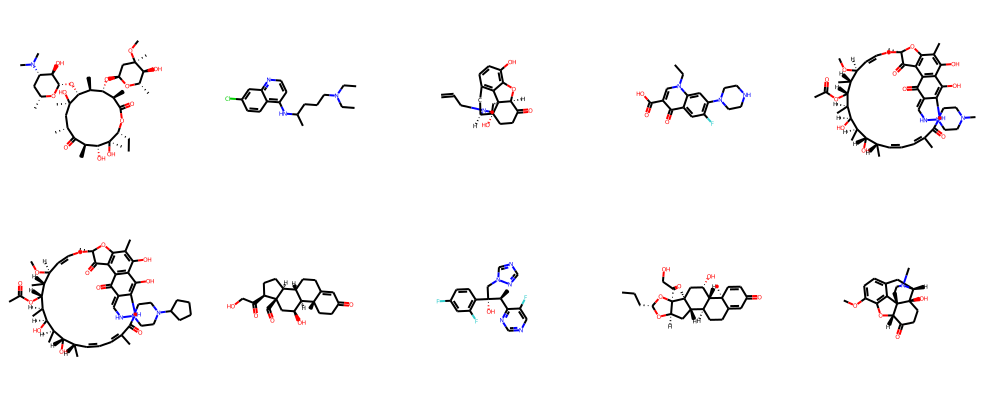

In [ ]:
# View Top 10 Structures
best_mols = ranked_candidate_df.smiles[:10].apply(Chem.MolFromSmiles)
Chem.Draw.MolsToGridImage(best_mols,molsPerRow=5)

We can also use the same logic to view a candidate molecule side by side with a treatment compound.

In [ ]:
# View top molecule vs most similar treatment with shared gene target
top_mol = Chem.MolFromSmiles(ranked_candidate_df.smiles[0])
ref_mol = Chem.MolFromSmiles(reference_drugs[ranked_candidate_df.reference_compounds[0][0]])
Chem.Draw.MolsToGridImage([top_mol, ref_mol], molsPerRow=2)

# Analyzing Top Molecule

Now we can look in depth at higest ranked molecule. By querrying Data Commons, we can find a more information about the drug and determine if it has been approved for human use.

In [ ]:
top_mol_dcid = ranked_candidate_df['candidate_dcid'].tolist()[0]
print('top candidate: ' + top_mol_dcid)

# get outgoing triple labels for the drug
out_labels = dc.get_property_labels([top_mol_dcid], out=True)[top_mol_dcid]
print('\nDrug properties we could examine:')
for label in out_labels:
  print(label)

print('\nSome specific values for bio/CHEMBL532:')
for label in ['administrationRoute', 'commonName', 'dosageForm', 'drugName', 'maximumFDAClinicalTrialPhase', 'propietaryName', 'recognizingAuthority', 'url']:
  value = dc.get_property_values([top_mol_dcid], label, out=True)[top_mol_dcid]
  print(label + ': ' + str(value))

Here we can see what information regarding this compound we can find in the Data Commons Knowledge Graph. We can also view details about the compound in the Data Commons Graph Browser [here](https://datacommons.org/browser/bio/CHEMBL532). We can also learn more by using the IDs listed above to find the drug in other databases like pubChem and ChEMBL.

In terms of finding a new application for a drug we first want to check what stage of clinical trials it has passed. Here, we see that erythromycin has a maximum FDA Clinical Trial Phase of 5, which means that it's approved and it completed the FDA post-market drug safety monitoring. This means this drug could be a candidate for off-label prescription use to treat Crohn's Disease.

It is important to consider whether a drug candidate has attributes that are appropriate for the proposed application of the compound. In this case for Crohn's Disease an administration route of a tablet would be appropriate. Next we should find out which company makes Erythromycin to see if this administration format is currently being produced and marketed. To do that we will examine the FDA application submitted for that particular drug strength. Each drug strength points to an FDA application submitted for that particular strength.

In [ ]:
# look at specific drug strength information
strength_dcid = ''
try: 
  strength_dcid = dc.get_property_values([top_mol_dcid], 'availableStrength', out=True)[top_mol_dcid]

  out_labels = dc.get_property_labels(strength_dcid, out=True)[strength_dcid[0]]
  print(strength_dcid)

  print('---Outgoing Drug Strength Triples---')
  for label in out_labels:
    value = dc.get_property_values(strength_dcid, label, out=True)[strength_dcid[0]]
    print(label + ': ' + str(value))
except:
    print('There is no FDA data for this compound.')

if strength_dcid:    
  print('\n')

  # look at FDA Application
  fda_app_dcid = dc.get_property_values(strength_dcid, 'submittedFDAApplication', out=True)[strength_dcid[0]]

  print(fda_app_dcid)

  out_labels = dc.get_property_labels(fda_app_dcid, out=True)[fda_app_dcid[0]]
  print('---Outgoing FDA Application Triples---')
  for label in out_labels:
    value = dc.get_property_values(fda_app_dcid, label, out=True)[fda_app_dcid[0]]
    print(label + ': ' + str(value))

['bio/CHEMBL532_Strength-208100-1_0', 'bio/CHEMBL532_Strength-208154-1_0', 'bio/CHEMBL532_Strength-209720-1_0', 'bio/CHEMBL532_Strength-209720-2_0', 'bio/CHEMBL532_Strength-210954-1_0', 'bio/CHEMBL532_Strength-210954-2_0', 'bio/CHEMBL532_Strength-210954-3_0', 'bio/CHEMBL532_Strength-50526-1_0', 'bio/CHEMBL532_Strength-50532-1_0', 'bio/CHEMBL532_Strength-50536-1_0', 'bio/CHEMBL532_Strength-50557-1_0', 'bio/CHEMBL532_Strength-50584-1_0', 'bio/CHEMBL532_Strength-50593-1_0', 'bio/CHEMBL532_Strength-50594-1_0', 'bio/CHEMBL532_Strength-50610-1_0', 'bio/CHEMBL532_Strength-50611-1_0', 'bio/CHEMBL532_Strength-50611-2_0', 'bio/CHEMBL532_Strength-50617-1_0', 'bio/CHEMBL532_Strength-60272-1_0', 'bio/CHEMBL532_Strength-60272-2_0', 'bio/CHEMBL532_Strength-61621-1_0', 'bio/CHEMBL532_Strength-61621-2_0', 'bio/CHEMBL532_Strength-61633-1_0', 'bio/CHEMBL532_Strength-62290-1_0', 'bio/CHEMBL532_Strength-62298-1_0', 'bio/CHEMBL532_Strength-62298-2_0', 'bio/CHEMBL532_Strength-62298-3_0', 'bio/CHEMBL532_Stren

From this information we can see the marketing status for the drug, the sponsor, and information about the submitted FDA application. We can see that Teligent Pharma Inc. filed the application. A quick google search reveals that Teligent Pharma Inc. only produces Erythromycin in gel and topical cream formats (https://www.teligent.com/pipeline-products/products/).

This would not be an appropriate administration route to treat Crohn's Disease, which is an inflammatory bowel disease. Therefore further work would need to be done to develop an alternative administration route for erythromycin before examining it's effectiveness at treating Crohn's Disease.

Finally, the last thing we may want to check is other diseases that this compound treats. We will do that here with one last query to Data Commons. To check the incoming triples for a given node, the out argument to get_property_labels must be set to False.


In [ ]:
# get incoming triple labels for the drug
in_labels = dc.get_property_labels([top_mol_dcid], out=False)[top_mol_dcid]
print('in labels: ' + str(in_labels))
print('\n---Incoming Triples---')
for label in in_labels:
  value = dc.get_property_values([top_mol_dcid], label, out=False)[top_mol_dcid]
  print(label + ' of ' + str(value))

try:
  print('\n' + top_mol_dcid + ' is known to treat:')
  # we want to find the side effects, we can do so by specifiying the type of 
  # incoming value we want to find
  treatment_nodes = dc.get_property_values([top_mol_dcid], 'compoundID', out=False, value_type='ChemicalCompoundDiseaseTreatment')[top_mol_dcid]
  treatment_lists = list(dc.get_property_values(treatment_nodes, 'diseaseID', out=True).values())
  diseases = [disease_list[0] for disease_list in treatment_lists]

  disease_names = list(dc.get_property_values(diseases, 'commonName', out=True).values())
  for name in disease_names:
    print(name)
except:
  print('There are no ChemicalCompoundDiseaseTreatment nodes involving this compound.')

From this information, we can conclude that this drug has been previously approved for human use. A researcher could gather all of the information above to begin more diagnostics, tests, and eventually trials to determine if this compound could be used as a treatment for the given disease.

We can perform the analysis above on any of the ranked or unranked candidates to find out more information about the compound. Now that candidiates have been identified, the next phase of drug discovery can begin in which the candidates are screened based on additional data about each compound.

# Conclusion
In this tutorial, we accessed data from different sources by querying Data Commons. We also found new compounds that may be good candidates to treat the disease `Crohn's disease`. If you'd like to examine drug candidates using this approach for a different disease, then make a copy of this notebook and change the input to your disease of interest.